# Model Comparison: Gemma 3 vs FinBERT

This notebook performs a comprehensive comparison between the Gemma 3 (with LoRA) and FinBERT models for financial sentiment analysis.

## Comparison Metrics
1. Accuracy
2. Precision, Recall, F1 Score
3. Cohen's Kappa
4. Matthews Correlation Coefficient
5. ROC-AUC Score
6. Confusion Matrix Analysis
7. Training Time and Resource Usage
8. Inference Speed

In [1]:
!pip install -q pandas numpy scikit-learn tqdm huggingface_hub
!pip install -U bitsandbytes typing_extensions
!pip install -U peft transformers accelerate tensorboard
!pip install -U matplotlib seaborn
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

In [2]:
from torch import nn

class GemmaForSequenceClassification(nn.Module):
    def __init__(self, base_model, tokenizer, num_labels=5):
        super().__init__()
        self.base_model = base_model
        self.tokenizer = tokenizer
        self.num_labels = num_labels
        self._config = base_model.config  # Store the config
        
        # Create the prompt template
        self.prompt = """You are a financial sentiment analyzer. Classify the given tweet's sentiment into one of these categories:

                        STRONGLY_POSITIVE - Very bullish, highly confident optimistic outlook
                        POSITIVE - Generally optimistic, bullish view
                        NEUTRAL - Factual, balanced, or no clear sentiment
                        NEGATIVE - Generally pessimistic, bearish view
                        STRONGLY_NEGATIVE - Very bearish, highly confident pessimistic outlook

                        Examples:
                        "Breaking: Company XYZ doubles profit forecast!" -> STRONGLY_POSITIVE
                        "Expecting modest gains next quarter" -> POSITIVE
                        "Market closed at 35,000" -> NEUTRAL
                        "Concerned about rising rates" -> NEGATIVE
                        "Crash incoming, sell everything!" -> STRONGLY_NEGATIVE

                        Format: Return only one word from: STRONGLY_POSITIVE, POSITIVE, NEUTRAL, NEGATIVE, STRONGLY_NEGATIVE

                        Analyze the sentiment of this tweet: """        
        self.prompt_ids = tokenizer.encode(self.prompt, add_special_tokens=False)

        # For Gemma 3, use model_dim instead of hidden_size
        if hasattr(base_model.config, "model_dim"):
            hidden_dim = base_model.config.model_dim
        elif hasattr(base_model.config, "hidden_size"):
            hidden_dim = base_model.config.hidden_size
        else:
            # Default value for Gemma 3 4B model is 262208
            print("Warning: Using default hidden dimension of 262208 for Gemma 3 model")
            hidden_dim = 262208
            
        print(f"Using hidden dimension: {hidden_dim}")

        # Get device and dtype from base model
        device = next(base_model.parameters()).device
        dtype = next(base_model.parameters()).dtype
        print(f"Base model device: {device}, dtype: {dtype}")

        # Create classifier with matching dtype and move to correct device
        self.classifier = nn.Linear(hidden_dim, num_labels, dtype=dtype).to(device)
        print(f"Moved classifier to device: {device}")

    # Add a property to expose the config
    @property
    def config(self):
        return self._config
        
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        batch_size = input_ids.shape[0]
        
        # Prepend prompt to each input
        prompt_ids_tensor = torch.tensor([self.prompt_ids] * batch_size, device=input_ids.device)
        modified_input_ids = torch.cat([prompt_ids_tensor, input_ids], dim=1)
        
        # Adjust attention mask
        prompt_attention = torch.ones(batch_size, len(self.prompt_ids), device=attention_mask.device)
        modified_attention_mask = torch.cat([prompt_attention, attention_mask], dim=1)
        
        # Run the model with the prompt
        outputs = self.base_model(
            input_ids=modified_input_ids, 
            attention_mask=modified_attention_mask
        )
        
        # For Gemma 3, handle different output structures
        if hasattr(outputs, "last_hidden_state"):
            hidden_states = outputs.last_hidden_state
        elif hasattr(outputs, "hidden_states") and outputs.hidden_states is not None:
            # Use the last layer's hidden states if available
            hidden_states = outputs.hidden_states[-1]
        else:
            # For CausalLM models, we can often use the logits
            # but first reshape them to get the hidden representation
            # print("Using logits for classification - this might not give optimal results")
            hidden_states = outputs.logits
        
        # Use a pooled representation of the sequence after the prompt
        # This combines the prompt context with the tweet content
        prompt_length = len(self.prompt_ids)
        
        # Extract non-prompt tokens
        relevant_states = hidden_states[:, prompt_length:, :]
        relevant_mask = modified_attention_mask[:, prompt_length:]
        
        # Mean pooling over the relevant tokens
        mask_expanded = relevant_mask.unsqueeze(-1).expand(relevant_states.size()).to(dtype=relevant_states.dtype)
        sum_hidden = torch.sum(relevant_states * mask_expanded, 1)
        count = torch.clamp(torch.sum(mask_expanded, 1), min=1e-9)  # Avoid division by zero
        pooled_output = sum_hidden / count
        
        # Apply the classification head
        logits = self.classifier(pooled_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            
        class SequenceClassifierOutput:
            def __init__(self, loss, logits):
                self.loss = loss
                self.logits = logits
        
        return SequenceClassifierOutput(loss, logits)
    
    # Add methods required for PEFT with CAUSAL_LM
    def prepare_inputs_for_generation(self, *args, **kwargs):
        """
        This method is required by PEFT for CAUSAL_LM task type.
        It delegates to the base model's method.
        """
        return self.base_model.prepare_inputs_for_generation(*args, **kwargs)

    def get_output_embeddings(self):
        """Return the output embeddings from the base model if needed for generation"""
        return self.base_model.get_output_embeddings()

    # Forward all attribute requests that we don't handle to the base model
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            # If we don't have the attribute, try getting it from base_model
            return getattr(self.base_model, name)

## Load Models and Data

In [3]:
# !pip install tensorflow tf-keras
# !pip install --upgrade transformers

In [4]:
# Load test data
test_data = pd.read_csv('/workspace/test.csv')
print(f"Loaded {len(test_data)} test samples")

from huggingface_hub import login
import os
import sys
import torch.nn as nn
hf_token = os.environ.get("HF_TOKEN", None)
if hf_token:
    login(token=hf_token)
else:
    print("⚠️ Hugging Face token not found! Please set the HF_TOKEN environment variable.")
    print("You need to log in to access Gemma 3, which is a gated model. Visit:")
    print("https://huggingface.co/google/gemma-3-4b-pt and accept the license")
    login() 

# Load Gemma 3 model with LoRA adapter
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

# Check for MPS availability
mps_available = torch.backends.mps.is_available()
gpu_available = torch.cuda.is_available()
device = torch.device("mps" if mps_available else "cuda" if gpu_available else "cpu")
print(f"MPS available: {mps_available}")
print(f"GPU available: {gpu_available}")
print(f"Using device: {device}")

# Initialize tokenizers
gemma_tokenizer = AutoTokenizer.from_pretrained('google/gemma-3-4b-pt', token=hf_token)
finbert_tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')

# First load the base model using AutoModelForCausalLM
base_model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-3-4b-pt",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    token=hf_token
)
base_model = base_model.to(device)
# Wrap with custom classification layer
gemma_model = GemmaForSequenceClassification(base_model, gemma_tokenizer, num_labels=5)
gemma_model = gemma_model.to(device)
# Then load the PEFT/LoRA adapter
gemma_model = PeftModel.from_pretrained(gemma_model, '/workspace/models/gemma3/gemma3_lora_adapter_best')
gemma_model = gemma_model.to(device)
print(f"Gemma model device: {next(gemma_model.parameters()).device}")
gemma_model.eval()

# Load FinBERT model with original number of labels (3)
finbert_model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
# Resize the classifier to 5 labels
hidden_size = finbert_model.config.hidden_size
finbert_model.config.num_labels = 5
finbert_model.num_labels = 5
# Replace the classifier with a new one that has 5 outputs
finbert_model.classifier = torch.nn.Linear(hidden_size, 5)

# Load safetensors model file using safetensors library
from safetensors.torch import load_file
state_dict = load_file('/workspace/models/finbert/model.safetensors')
finbert_model.load_state_dict(state_dict)
finbert_model = finbert_model.to(device)
print(f"FinBERT model device: {next(finbert_model.parameters()).device}")
finbert_model.eval()

# Map sentiment labels to numeric values (0-4)
sentiment_mapping = {
    'STRONGLY_POSITIVE': 0,
    'POSITIVE': 1,
    'NEUTRAL': 2,
    'NEGATIVE': 3,
    'STRONGLY_NEGATIVE': 4
}
# Convert sentiment labels to numeric
test_data['label'] = test_data['sentiment'].map(lambda x: sentiment_mapping.get(x, 2))


Loaded 7000 test samples
MPS available: False
GPU available: True
Using device: cuda


/usr/local/lib/python3.11/dist-packages/transformers/models/auto/modeling_auto.py:1682: FutureWarning: Loading a multimodal model with `AutoModelForCausalLM` is deprecated and will be removed in v5. `AutoModelForCausalLM` will be used to load only the text-to-text generation module.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using hidden dimension: 262208
Base model device: cuda:0, dtype: torch.bfloat16
Moved classifier to device: cuda:0
Gemma model device: cuda:0
FinBERT model device: cuda:0


## Evaluation Functions

In [12]:
def evaluate_model(model, tokenizer, texts, labels, batch_size=32):
    predictions = []
    true_labels = []
    inference_times = []
    prediction_probs = []  # Store probabilities for ROC-AUC
    device = next(model.parameters()).device  # Get the device from the model
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]
        batch_labels = labels[i:i + batch_size]
        
        # Tokenize
        inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=128, return_tensors='pt')
        # Move inputs to the same device as the model
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Measure inference time
        start_time = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
            # Store both predictions and probabilities
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)
        inference_time = time.time() - start_time
        
        # Move predictions back to CPU for numpy conversion
        preds_cpu = preds.cpu().numpy()
        
        predictions.extend(preds_cpu)
        prediction_probs.extend(probs.cpu().float().numpy()) # Convert to float32 before numpy
        true_labels.extend(batch_labels)
        inference_times.extend([inference_time / len(batch_texts)] * len(batch_texts))
        
    # Convert to numpy arrays
    predictions = np.array(predictions)
    prediction_probs = np.array(prediction_probs)
    true_labels = np.array(true_labels)
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_recall_fscore_support(true_labels, predictions, average='weighted')[0],
        'recall': precision_recall_fscore_support(true_labels, predictions, average='weighted')[1],
        'f1': precision_recall_fscore_support(true_labels, predictions, average='weighted')[2],
        'kappa': cohen_kappa_score(true_labels, predictions),
        'mcc': matthews_corrcoef(true_labels, predictions),
        # 'roc_auc': roc_auc_score(true_labels, predictions, multi_class='ovr'),
        'avg_inference_time': np.mean(inference_times),
        'confusion_matrix': confusion_matrix(true_labels, predictions)
    }
    
    return metrics

## Run Evaluation

In [14]:

# Replace the original evaluation call:
print("Evaluating Gemma 3 model...")
gemma_metrics = evaluate_model(
    model=gemma_model, # Pass the loaded model
    tokenizer=gemma_tokenizer,
    texts=test_data['description'].tolist(),
    labels=test_data['label'].tolist()
)

# Keep the FinBERT evaluation as is
print("\nEvaluating FinBERT model...")
finbert_metrics = evaluate_model(finbert_model, finbert_tokenizer, test_data['description'].tolist(), test_data['label'].tolist())

Evaluating Gemma 3 model...


  0%|          | 0/219 [00:00<?, ?it/s]


Evaluating FinBERT model...


  0%|          | 0/219 [00:00<?, ?it/s]

## Visualize Results

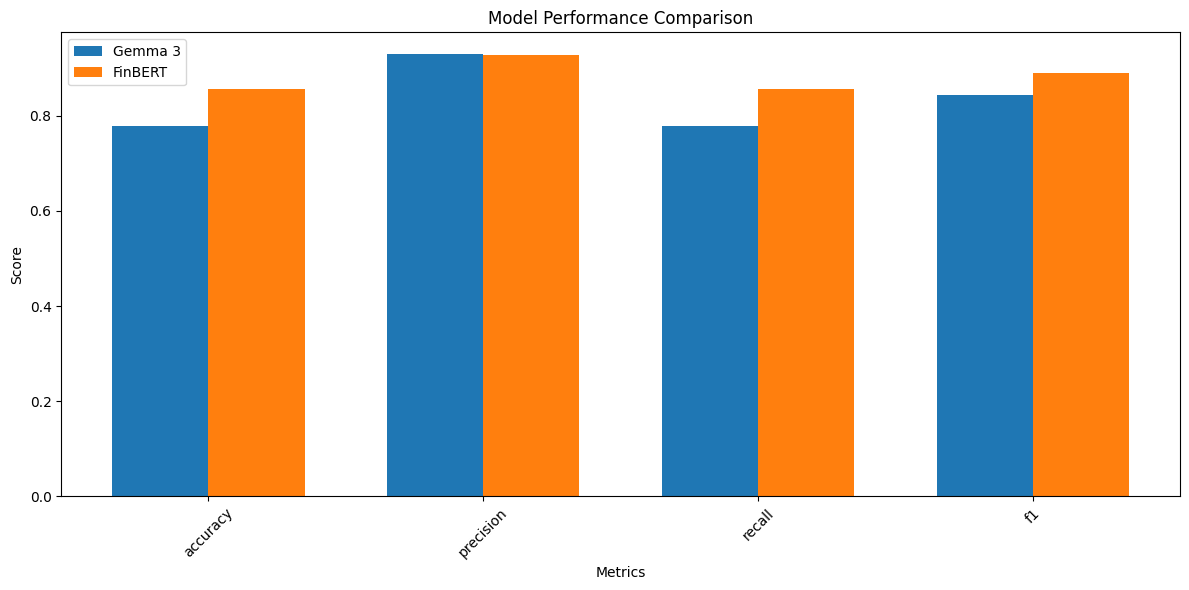

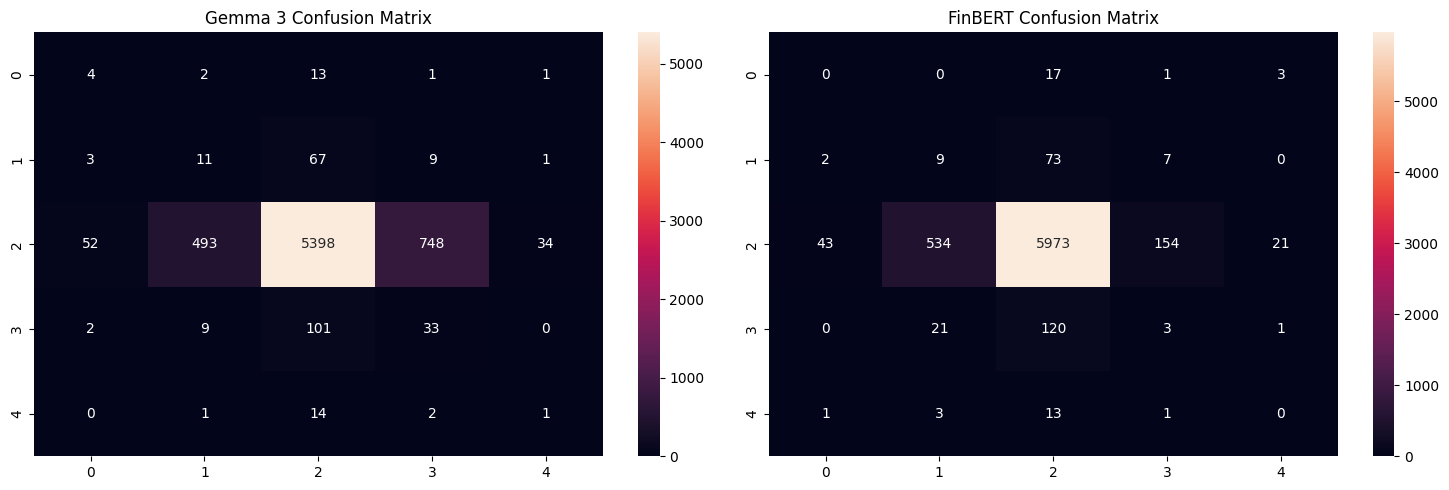

In [18]:
def plot_metrics_comparison(gemma_metrics, finbert_metrics):
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    models = ['Gemma 3', 'FinBERT']
    
    plt.figure(figsize=(12, 6))
    x = np.arange(len(metrics))
    width = 0.35
    
    plt.bar(x - width/2, [gemma_metrics[m] for m in metrics], width, label='Gemma 3')
    plt.bar(x + width/2, [finbert_metrics[m] for m in metrics], width, label='FinBERT')
    
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, metrics, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(gemma_metrics, finbert_metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot Gemma 3 confusion matrix
    sns.heatmap(gemma_metrics['confusion_matrix'], annot=True, fmt='d', ax=ax1)
    ax1.set_title('Gemma 3 Confusion Matrix')
    
    # Plot FinBERT confusion matrix
    sns.heatmap(finbert_metrics['confusion_matrix'], annot=True, fmt='d', ax=ax2)
    ax2.set_title('FinBERT Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

# Plot comparisons
plot_metrics_comparison(gemma_metrics, finbert_metrics)
plot_confusion_matrices(gemma_metrics, finbert_metrics)

## Print Detailed Results

In [16]:
def print_metrics(metrics, model_name):
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Cohen's Kappa: {metrics['kappa']:.4f}")
    print(f"Matthews Correlation Coefficient: {metrics['mcc']:.4f}")
    # print(f"ROC-AUC Score: {metrics['roc_auc']:.4f}")
    print(f"Average Inference Time: {metrics['avg_inference_time']*1000:.2f} ms")

print_metrics(gemma_metrics, "Gemma 3")
print_metrics(finbert_metrics, "FinBERT")


Gemma 3 Results:
Accuracy: 0.7781
Precision: 0.9286
Recall: 0.7781
F1 Score: 0.8443
Cohen's Kappa: 0.0314
Matthews Correlation Coefficient: 0.0444
Average Inference Time: 15.03 ms

FinBERT Results:
Accuracy: 0.8550
Precision: 0.9267
Recall: 0.8550
F1 Score: 0.8890
Cohen's Kappa: 0.0207
Matthews Correlation Coefficient: 0.0242
Average Inference Time: 0.11 ms


## Analysis and Conclusions

In [19]:
def analyze_results(gemma_metrics, finbert_metrics):
    print("\nAnalysis:")
    
    # Compare accuracy
    acc_diff = gemma_metrics['accuracy'] - finbert_metrics['accuracy']
    print(f"Accuracy Difference: {acc_diff:.4f} ({'Gemma 3' if acc_diff > 0 else 'FinBERT'} better)")
    
    # Compare F1 scores
    f1_diff = gemma_metrics['f1'] - finbert_metrics['f1']
    print(f"F1 Score Difference: {f1_diff:.4f} ({'Gemma 3' if f1_diff > 0 else 'FinBERT'} better)")
    
    # Compare inference times
    time_diff = gemma_metrics['avg_inference_time'] - finbert_metrics['avg_inference_time']
    print(f"Inference Time Difference: {time_diff*1000:.2f} ms ({'FinBERT' if time_diff > 0 else 'Gemma 3'} faster)")
    
    # Analyze confusion matrices
    print("\nConfusion Matrix Analysis:")
    for model_name, metrics in [('Gemma 3', gemma_metrics), ('FinBERT', finbert_metrics)]:
        cm = metrics['confusion_matrix']
        print(f"\n{model_name}:")
        print(f"Most Confused Classes: {np.unravel_index(cm.argmax(), cm.shape)}")
        print(f"Diagonal Sum (Correct Predictions): {np.sum(np.diag(cm))}")

analyze_results(gemma_metrics, finbert_metrics)


Analysis:
Accuracy Difference: -0.0769 (FinBERT better)
F1 Score Difference: -0.0447 (FinBERT better)
Inference Time Difference: 14.92 ms (FinBERT faster)

Confusion Matrix Analysis:

Gemma 3:
Most Confused Classes: (np.int64(2), np.int64(2))
Diagonal Sum (Correct Predictions): 5447

FinBERT:
Most Confused Classes: (np.int64(2), np.int64(2))
Diagonal Sum (Correct Predictions): 5985
